In [1]:
# default_exp gan.learner

# gan.learner

> API details.

In [2]:
# export

import torch
import torch.nn as nn
import matplotlib.pyplot as plt

from tqdm import tqdm
from fastrenewables.synthetic_data import *
from fastrenewables.gan.model import *

#import glob

In [3]:
# export

class GANLearner():
    def __init__(self, gan, n_gen=1, n_dis=1):
        super(GANLearner, self).__init__()
        # gan should contain a class which itself contains a generator and discriminator/critic class and combines them
        self.gan = gan
        self.n_gen = n_gen
        self.n_dis = n_dis
   
    def generate_samples(self, x):
        z = self.gan.noise(x)
        fake_samples = self.gan.generator(None, z).detach()
        return fake_samples
    
    def fit(self, dl, epochs=10, plot_epochs=10, save_model=False):
        
        self.gan.to_device(self.gan.device)
        for e in tqdm(range(epochs)):
            for x_cat, x_cont, y in dl:
                x_cat = x_cat.to(self.gan.device)
                x_cont = x_cont.to(self.gan.device)
                y = y.to(self.gan.device)
                if y.dim() == 3:
                    y = y.flatten(1, 2)[:, 0]
                
                for _ in range(self.n_dis):
                    self.gan.train_discriminator(x_cat, x_cont, y)

                for _ in range(self.n_gen):
                    self.gan.train_generator(x_cat, x_cont, y)
                
            if (e+1)%plot_epochs==0:
                plt.figure(figsize=(16, 9))
                plt.plot(self.gan.real_loss, label='Real Loss')
                plt.plot(self.gan.fake_loss, label='Fake Loss')
                plt.legend()
                plt.show()
        
        if save_model:
            self.gan.to_device('cpu')
        
        return

### Examples:

bce mlp


 99%|█████████▉| 99/100 [00:01<00:00, 64.59it/s]

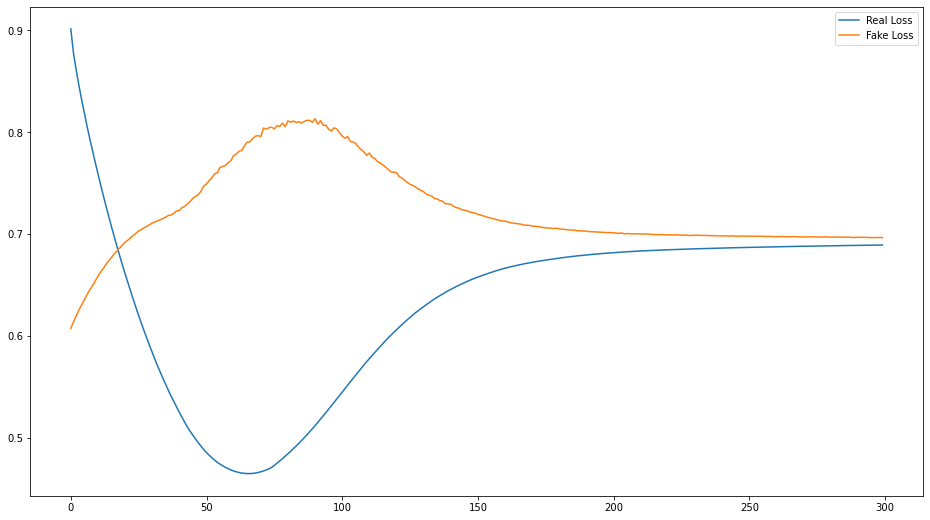

100%|██████████| 100/100 [00:01<00:00, 50.78it/s]


bce cnn


 98%|█████████▊| 98/100 [00:01<00:00, 60.06it/s]

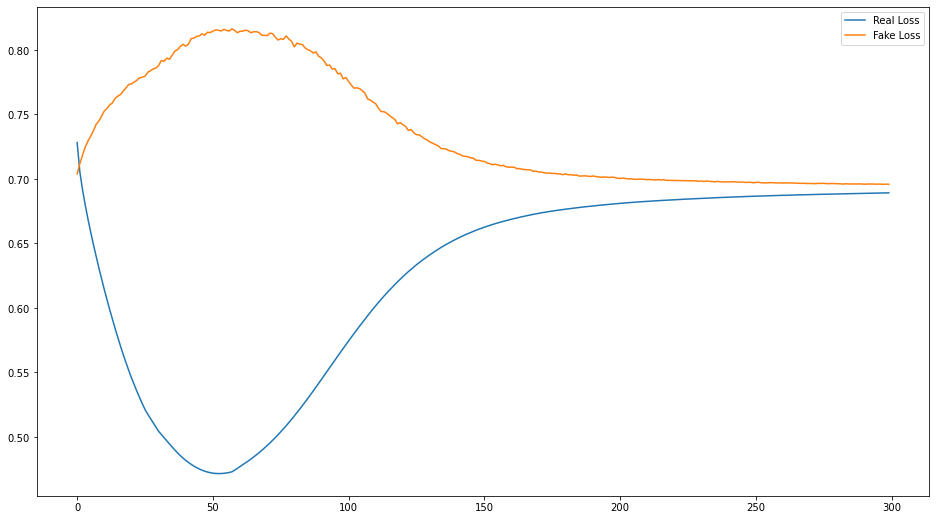

100%|██████████| 100/100 [00:01<00:00, 57.36it/s]


aux mlp


 96%|█████████▌| 96/100 [00:01<00:00, 54.05it/s]

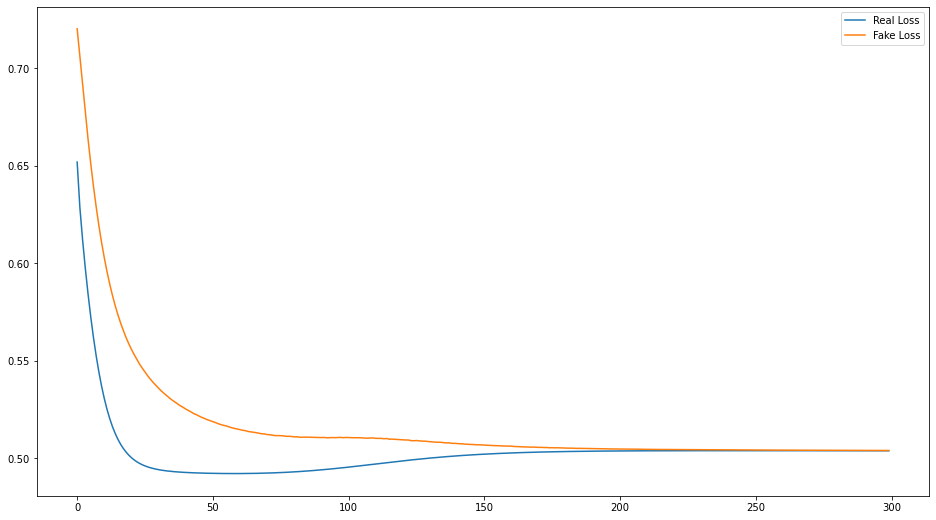

100%|██████████| 100/100 [00:01<00:00, 50.94it/s]


aux cnn


 96%|█████████▌| 96/100 [00:01<00:00, 45.10it/s]

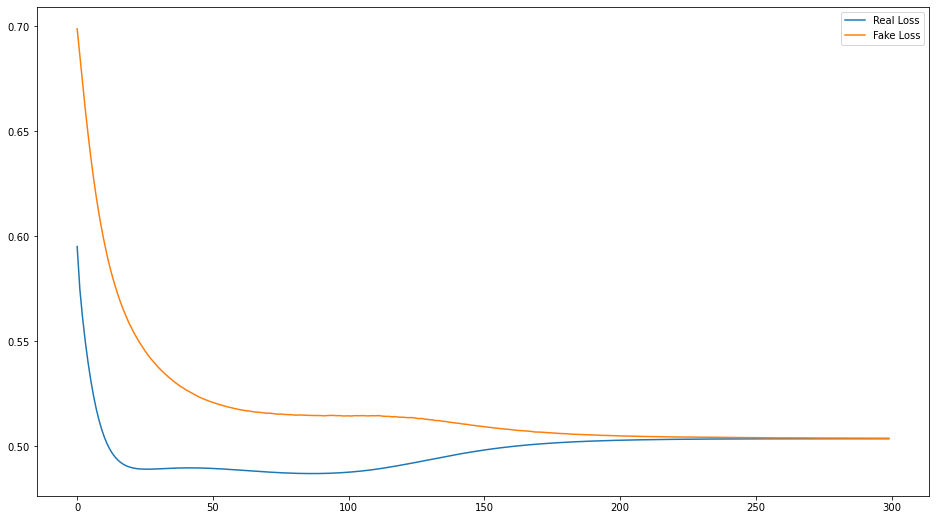

100%|██████████| 100/100 [00:02<00:00, 49.48it/s]


wgan mlp


 96%|█████████▌| 96/100 [00:02<00:00, 32.54it/s]

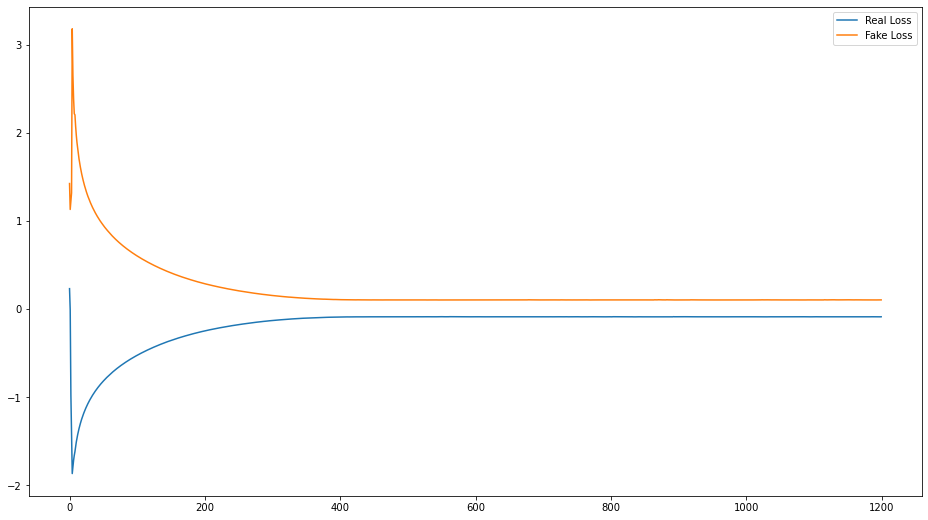

100%|██████████| 100/100 [00:03<00:00, 31.40it/s]


wgan cnn


 96%|█████████▌| 96/100 [00:02<00:00, 32.53it/s]

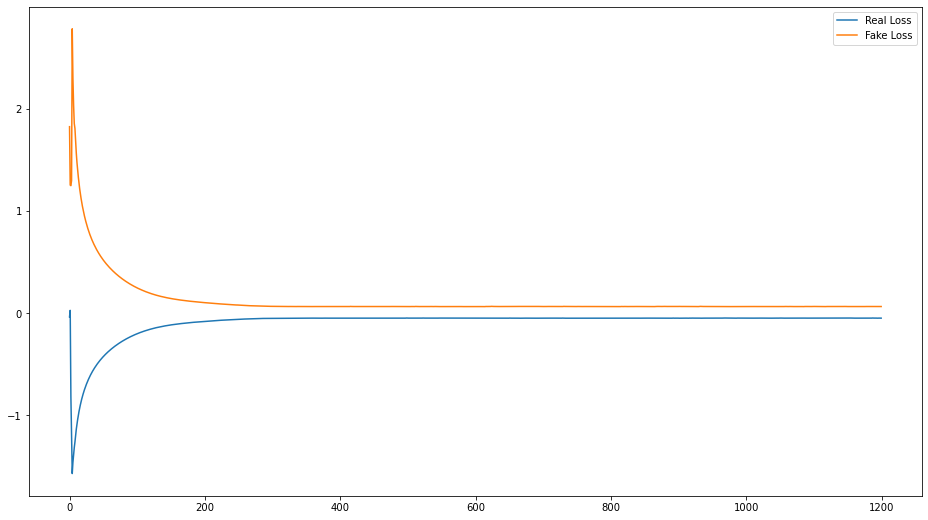

100%|██████████| 100/100 [00:03<00:00, 31.39it/s]


In [4]:
n_z = 100
n_cat_feats = 4
n_cont_feats = 4
n_targets = 1
len_ts = 24
n_samples = 1000
n_classes = 2
batch_size = 256
epochs = 100

for gan_type in ['bce', 'aux', 'wgan']:
    for model_type in ['mlp', 'cnn']:
        print(gan_type, model_type)
        structure = [n_z, 64, n_cont_feats]

        model_type = 'mlp'

        if gan_type == 'wgan':
            n_gen = 1
            n_dis = 4
        else:
            n_gen = 1
            n_dis = 1

        if model_type == 'mlp':
            n_dim = 2
        elif model_type == 'cnn':
            n_dim = 3

        model = get_gan_model(gan_type=gan_type, model_type=model_type, structure=structure, len_ts=len_ts, n_classes=n_classes)
        data = DummyDataset(n_samples=n_samples, n_cat_feats=n_cat_feats, n_cont_feats=n_cont_feats, n_targets=n_targets, len_ts=len_ts, n_dim=n_dim)
        #data = SineDataset(n_samples=n_samples, n_classes=n_classes, n_features=n_cont_feats, noise=0)
        dl = torch.utils.data.DataLoader(data, batch_size=batch_size, shuffle=True, drop_last=True)
        learner = GANLearner(gan=model, n_gen=n_gen, n_dis=n_dis)
        learner.fit(dl, epochs=epochs, plot_epochs=epochs)

In [5]:
#n_z = 100
#n_cat_feats = 4
#n_cont_feats = 4
#n_targets = 1
#len_ts = 24
#n_samples = 1000
#n_classes = 2
#batch_size = 256
#epochs = 100
#structure = [n_z, 64, n_cont_feats]
#
#gan_type = 'aux'
#model_type = 'mlp'
#        
#if gan_type == 'wgan':
#    n_gen = 1
#    n_dis = 4
#else:
#    n_gen = 1
#    n_dis = 1
#
#if model_type == 'mlp':
#    n_dim = 2
#elif model_type == 'cnn':
#    n_dim = 3
#
#model = get_gan_model(gan_type=gan_type, model_type=model_type, structure=structure, len_ts=len_ts, n_classes=n_classes)
#print(model)
#data = DummyDataset(n_samples=n_samples, n_cat_feats=n_cat_feats, n_cont_feats=n_cont_feats, n_targets=n_targets, len_ts=len_ts, n_dim=n_dim)
##data = SineDataset(n_samples=n_samples, n_classes=n_classes, n_features=n_cont_feats, noise=0)
#dl = torch.utils.data.DataLoader(data, batch_size=batch_size, shuffle=True, drop_last=True)
#learner = GANLearner(gan=model, n_gen=n_gen, n_dis=n_dis)
#learner.fit(dl, epochs=epochs, plot_epochs=epochs)

# Tests:

In [6]:
for x_cat, x_cont, y in dl:
    break
x_fake = learner.generate_samples(x_cont).cpu()
x_fake, x_fake.shape

(tensor([[0.9999, 0.9999, 0.9999, 0.9998],
         [0.9974, 0.9991, 0.9971, 0.9968],
         [0.9969, 0.9999, 0.9997, 0.9997],
         ...,
         [0.9958, 0.9992, 0.9976, 0.9994],
         [0.9965, 0.9980, 0.9958, 0.9964],
         [0.9998, 0.9997, 0.9999, 0.9998]]),
 torch.Size([256, 4]))

In [7]:
if n_dim == 3:
    plt.figure(figsize=(16, 9))
    for f in range(n_cont_feats):
        plt.subplot(2, 2, f+1)
        plt.plot(x_cont[0, f, :], label='real')
        plt.plot(x_fake[0, f, :], label='fake')
        plt.legend()
    plt.show()

In [8]:
#if config['model_type'] == 'mlp':
#    data = DummyDataset()
#    model_fct = GANMLP
#elif config['model_type'] == 'cnn':
#    data = SineDataset()
#    model_fct = GANCNN
#dl = torch.utils.data.DataLoader(data, batch_size=32, shuffle=True, drop_last=True)
#for x_cat, x_cont, y in dl:
#    print(x_cat.shape, x_cont.shape, y.shape)
#    break
#
#n_cont_feats = x_cont.shape[1]
#gen_structure = [config['n_noise_samples'], 64, n_cont_feats]
#dis_structure = [n_cont_feats, 64, 1]
#
#generator = model_fct(gen_structure, final_activation=config['final_activation_gen'], cnn_type='cnn' ,transpose=True)
#if config['auxiliary']:
#    n_classes = x_cont.shape[1]
#    input_size = dis_structure[-2]
#    discriminator = model_fct(dis_structure[:-1], final_activation=config['final_activation_dis'], cnn_type='cnn')
#    discriminator = AuxiliaryDiscriminator(discriminator, n_classes, input_size,len_ts=x_cont.shape[-1], model_type=config['model_type'])
#else:
#    discriminator = model_fct(dis_structure, final_activation=config['final_activation_dis'], cnn_type='cnn')
#
#gen_optim = torch.optim.RMSprop(generator.parameters(), lr=config['lr'])
#dis_optim = torch.optim.RMSprop(discriminator.parameters(), lr=config['lr'])
#gan = Gan(generator, discriminator, gen_optim, dis_optim, auxiliary=config['auxiliary'])
#learn = GanLearner(gan)
#
#learn.device = torch.device('cpu')
#learn.fit(dl, epochs=config['epochs'], plot_epochs=config['epochs'])
#
#learn.device = torch.device('cpu')
#
#x_real = x_cont.reshape(1, -1)
#x_fake = learn.generate_samples(x_cont).reshape(1, -1)
#
#plt.figure(figsize=(16, 9))
#plt.hist(x_real, bins=50, label='real', alpha=0.7, density=True)
#plt.hist(x_fake, bins=50, label='fake', alpha=0.7, density=True)
#plt.legend()
#plt.show()

In [9]:
#for i in range(x_cont.shape[1]):
#    plt.figure(figsize=(16, 9))
#    plt.plot(x_cont[0, i, :])
#    plt.plot(learn.generate_samples(x_cont)[0, i, :])
#    plt.show()